In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor


from google.colab import files

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


In [2]:
try:
  import catboost
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.4 MB/s eta 0:00:00


In [3]:
real_data = r'/content/drive/MyDrive/datasets/strokeprediction/stroke data/healthcare-dataset-stroke-data.csv'
train_data = r'/content/drive/MyDrive/datasets/strokeprediction/stroke data - generated/train.csv'
test_data  = r'/content/drive/MyDrive/datasets/strokeprediction/stroke data - generated/test.csv'

df = pd.read_csv(train_data)
test = pd.read_csv(test_data)
dff = pd.read_csv(real_data)

In [4]:
saving_folder = r'/content/drive/MyDrive/Colab Notebooks/predictions'

def kaggle_submission(trained_model, test_data, savename="my_predictions", neural=False):
  predictions = trained_model.predict(test_data)
  if neural:
    predictions = [pred for [pred] in predictions]
  indices = range(15304, 25508)
  sub_df = pd.DataFrame(zip(indices, predictions) , columns=["id", "stroke"])
  with open(f"{saving_folder}/{savename}.csv", 'w', encoding = 'utf-8-sig') as f:
    sub_df.to_csv(f, index=False)
  files.download(f"{saving_folder}/{savename}.csv")


def standardize_features( dataframe: pd.DataFrame, feature_names: list, standardize=True):
  """standardizes numerical features and returns a dataframe"""
  from sklearn.preprocessing import StandardScaler, Normalizer
  if not standardize:
    operator = Normalizer()
  else:
    operator = StandardScaler()
  df = dataframe
  for column_name in feature_names:
      raw_data = np.array(df[column_name]).reshape(-1, 1)
      transformed = operator.fit_transform(raw_data)
      ready = pd.DataFrame(transformed, columns=[column_name])
      df = df.drop(column_name, axis=1).join(ready)
  return df

In [5]:
len(range(15304, 25505))

10201

In [6]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0
15302,15302,Male,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0


# looking at the real data first

In [7]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
dff["bmi"] = dff.bmi.fillna(df.bmi.median())

In [9]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [10]:
dfff = pd.get_dummies(dff)  # for working with models

Looking at the categories balance. Real data is rarely balanced

In [11]:
dff.stroke.value_counts()

# unbalanced!

0    4861
1     249
Name: stroke, dtype: int64

In [12]:
df.stroke.value_counts()


# the generated data is also unbalanced

0    14672
1      632
Name: stroke, dtype: int64

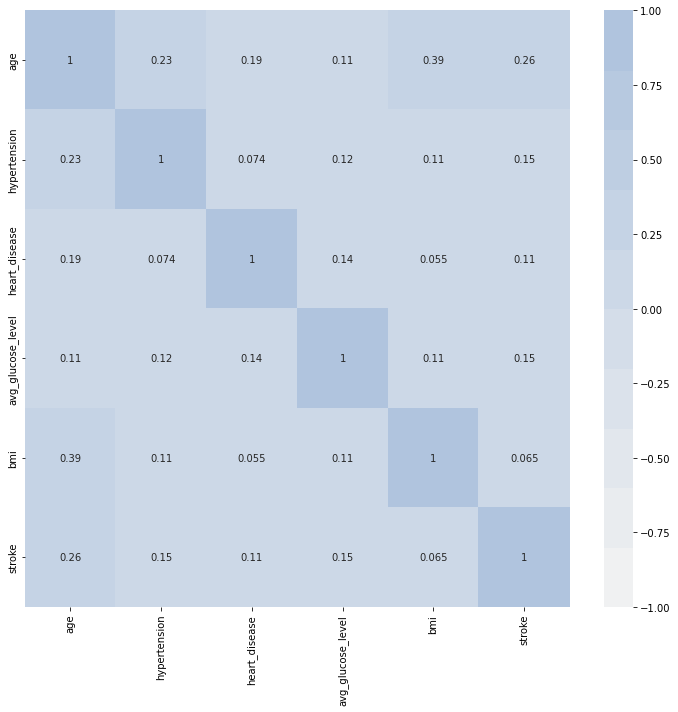

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df.drop("id", axis=1).corr(), vmin=-1, vmax=1, annot=True, 
                 cmap=sns.light_palette("lightsteelblue",n_colors=10, reverse=False),
                 ax=ax)

plt.tight_layout()
plt.show()

<ipython-input-14-443b2df9307c>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = dff[df.stroke == 0][ft].sample(len(dff[dff.stroke == 1])).value_counts()
<ipython-input-14-443b2df9307c>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2 = dff[df.stroke == 1][ft].value_counts()


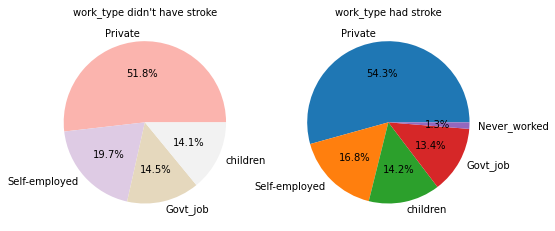

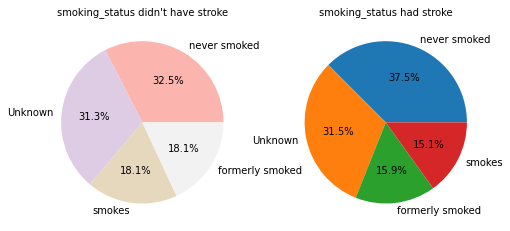

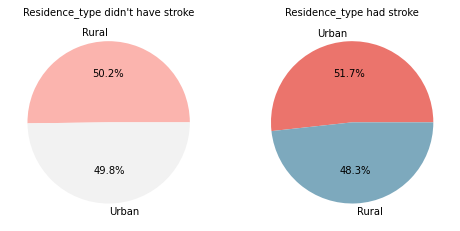

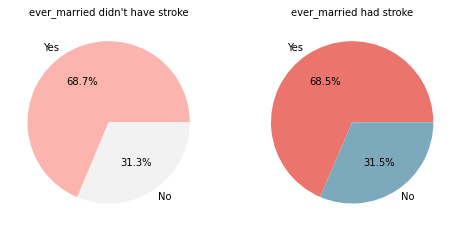

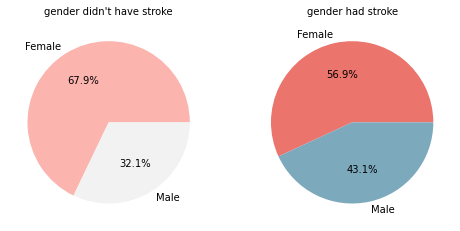

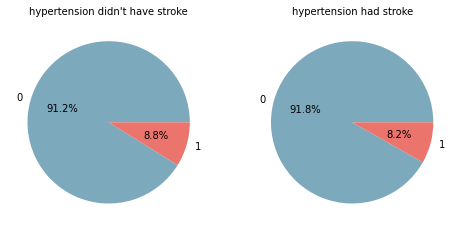

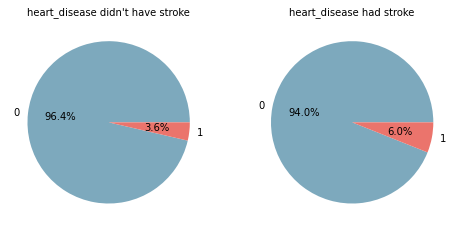

In [14]:
features =  ["work_type", "smoking_status", "Residence_type", "ever_married", "gender", "hypertension", "heart_disease"]

def color_func(pct): return "blue" if pct > 50 else "red"

for ft in features:
    data1 = dff[df.stroke == 0][ft].sample(len(dff[dff.stroke == 1])).value_counts()
    data2 = dff[df.stroke == 1][ft].value_counts()

    colors1 = plt.cm.Pastel1(np.linspace(0, 1, len(data1)))
    positive_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    is_numeric = np.issubdtype(dff[ft].dtype, np.number)
    if len(data2.unique()) == 2:
        positive_colors =  ["#7da9bd", "#eb746c"] if is_numeric else ["#eb746c", "#7da9bd"]
    colors1 = positive_colors if is_numeric else colors1    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.pie(data1, labels=data1.index, autopct="%0.1f%%", colors=colors1)
    ax1.set_title(f"{ft} didn't have stroke",size = 10)
    ax2.pie(data2, labels=data2.index, autopct="%0.1f%%", colors =positive_colors)
    ax2.set_title(f"{ft} had stroke", size = 10)
    plt.show()

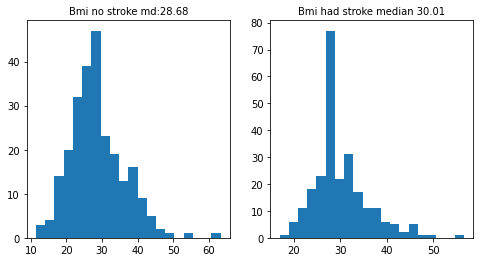

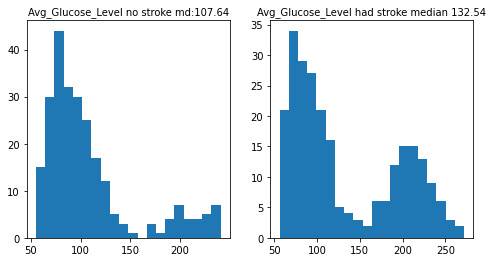

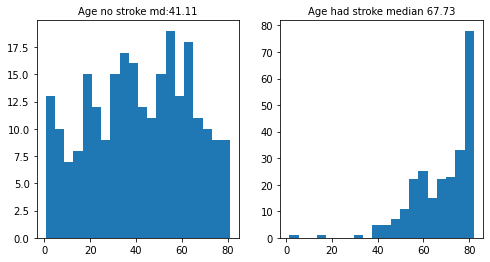

In [15]:
features =  ["bmi", "avg_glucose_level","age" ]

for ft in features:
    data1 = dff[dff.stroke == 0][ft].sample(len(dff[dff.stroke == 1]))
    data2 = dff[dff.stroke == 1][ft]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.hist(data1,bins=20)
    ax1.set_title(f"{ft.title()} no stroke md:{round(data1.mean(),2)}", size = 10)
    ax2.hist(data2,bins=20)
    ax2.set_title(f"{ft.title()} had stroke median {round(data2.mean(),2)}", size = 10)
    plt.show()

# joining the data

In [16]:
df = pd.concat([df, dff], axis = 0, ignore_index= True)

one-encoding 

In [17]:
df = pd.get_dummies(df, drop_first=True)
test = pd.get_dummies(test,drop_first=True)
# besides ID, some features are deleted after checking best_params of xgbboost model
# could also use PCA, but it's maybe too much
df.drop(["id", "gender_Other", 'work_type_children'], axis=1, inplace=True)
test.drop(["id", "gender_Other",'work_type_children'], axis=1, inplace=True)

In [18]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [19]:
x = df.drop("stroke",axis=1)
y = df.stroke

assert (x.columns == test.columns).all()

In [20]:
x_train_full, x_test, y_train_full, y_test =  train_test_split(x, y, test_size=0.1)                  


# feature engineering

In [21]:
# features ideas from  JOSE CÁLIZ   :V kind of looks lame


def generate_features(df):
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
    df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    df['blood_heart']= df.hypertension * df.heart_disease
    return df

# Oversampling smaller class with SMOTE
[qinchao's notebook](https://www.kaggle.com/code/qianchao/smote-with-imbalance-data)

In [26]:
print(f"Before OverSampling, counts of label '1': {sum(y_train_full==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train_full==0)} .\n")

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(x_train_full, y_train_full.ravel())

print(f'After OverSampling, the shape of train_X: {X_train_res.shape}')
print(f'After OverSampling, the shape of train_y: {y_train_res.shape} \n')

print(f"After OverSampling, counts of label '1': {sum(y_train_res==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_res==0)}")


Before OverSampling, counts of label '1': 795
Before OverSampling, counts of label '0': 17577 .

After OverSampling, the shape of train_X: (35154, 14)
After OverSampling, the shape of train_y: (35154,) 

After OverSampling, counts of label '1': 17577
After OverSampling, counts of label '0': 17577


In [27]:
val_size = 3500
x_valid, x_train =  X_train_res[:val_size], X_train_res[val_size:]
y_valid, y_train =  y_train_res[:val_size], y_train_res[val_size:]

In [28]:
# specify the parameter grid for the xgboost regressor
param_grid = {'n_estimators': range(100,300),
              'learning_rate': np.linspace(0.01,1,101),
}

# create the regressor
xgbr = XGBRegressor(random_state=42)

# create the randomized search
random_search = RandomizedSearchCV(xgbr, param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1)
#random_search.fit(X_train_res, y_train_res)
#random_search.best_params_


In [29]:
#xgb_better = XGBRegressor(n_estimators=300, learning_rate = 0.01) # getting 0.83!
#xgb_better = random_search.best_estimator_   # bad

In [30]:
xgb_better = XGBRegressor(n_estimators=300, learning_rate = 0.001)
xgb_better.fit(X_train_res, y_train_res)
preds = xgb_better.predict(x_test)
roc_auc_score(y_test, preds)

[17:11:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.838576592000761

In [31]:
#kaggle_submission(xgb_better,test,"xgb after deleting features")

In [32]:
def ft_importances(importances, train_df):
  for i, pct in enumerate(importances):
    print(f"{train_df.columns[i]} : {round(pct,4)}")

ft_importances(xgb_better.feature_importances_, X_train_res)

age : 0.5781999826431274
hypertension : 0.0
heart_disease : 0.0
avg_glucose_level : 0.0
bmi : 0.0
gender_Male : 0.03290000185370445
ever_married_Yes : 0.022199999541044235
work_type_Never_worked : 0.0
work_type_Private : 0.0
work_type_Self-employed : 0.08290000259876251
Residence_type_Urban : 0.02930000051856041
smoking_status_formerly smoked : 0.10610000044107437
smoking_status_never smoked : 0.148499995470047
smoking_status_smokes : 0.0


In [33]:
cat_boost = CatBoostRegressor(random_seed = 33, n_estimators=300, max_depth=2, learning_rate = 0.005)
cat_boost.fit(X_train_res, y_train_res)
preds = cat_boost.predict(x_test)
roc_auc_score(y_test, preds)

0:	learn: 0.4989467	total: 57.5ms	remaining: 17.2s
1:	learn: 0.4979063	total: 62.9ms	remaining: 9.37s
2:	learn: 0.4968693	total: 67.1ms	remaining: 6.64s
3:	learn: 0.4958956	total: 70.6ms	remaining: 5.22s
4:	learn: 0.4948735	total: 76.3ms	remaining: 4.5s
5:	learn: 0.4938489	total: 84.9ms	remaining: 4.16s
6:	learn: 0.4928467	total: 89.7ms	remaining: 3.76s
7:	learn: 0.4918657	total: 98.2ms	remaining: 3.58s
8:	learn: 0.4908751	total: 107ms	remaining: 3.45s
9:	learn: 0.4898868	total: 119ms	remaining: 3.45s
10:	learn: 0.4889104	total: 125ms	remaining: 3.28s
11:	learn: 0.4879313	total: 133ms	remaining: 3.2s
12:	learn: 0.4869623	total: 146ms	remaining: 3.23s
13:	learn: 0.4860451	total: 155ms	remaining: 3.17s
14:	learn: 0.4851033	total: 160ms	remaining: 3.04s
15:	learn: 0.4841686	total: 169ms	remaining: 3s
16:	learn: 0.4832461	total: 176ms	remaining: 2.93s
17:	learn: 0.4823230	total: 185ms	remaining: 2.9s
18:	learn: 0.4814155	total: 193ms	remaining: 2.86s
19:	learn: 0.4804954	total: 204ms	remai

0.8348641032957625

In [34]:
#kaggle_submission(cat_boost ,test,"catboost")